2021-05-31
Final Portfolio Value: 1000000.00
2021-06-30
Final Portfolio Value: 998969.92
2021-07-30
Final Portfolio Value: 1074980.11
2021-08-31
Final Portfolio Value: 1287866.40
2021-09-30
Final Portfolio Value: 1230639.09
2021-10-29
Final Portfolio Value: 1309581.62
2021-11-30
Final Portfolio Value: 791341.53
2021-12-31
Final Portfolio Value: 971315.18
value: 971315.180644989
SharpeRatio: OrderedDict([('sharperatio', -1.4628441537521504)])
DrawDown: AutoOrderedDict([('len', 2), ('drawdown', 25.83011528271957), ('moneydown', 338266.4431467056), ('max', AutoOrderedDict([('len', 2), ('drawdown', 39.57295131763641), ('moneydown', 518240.0984477997)]))])


<IPython.core.display.Javascript object>


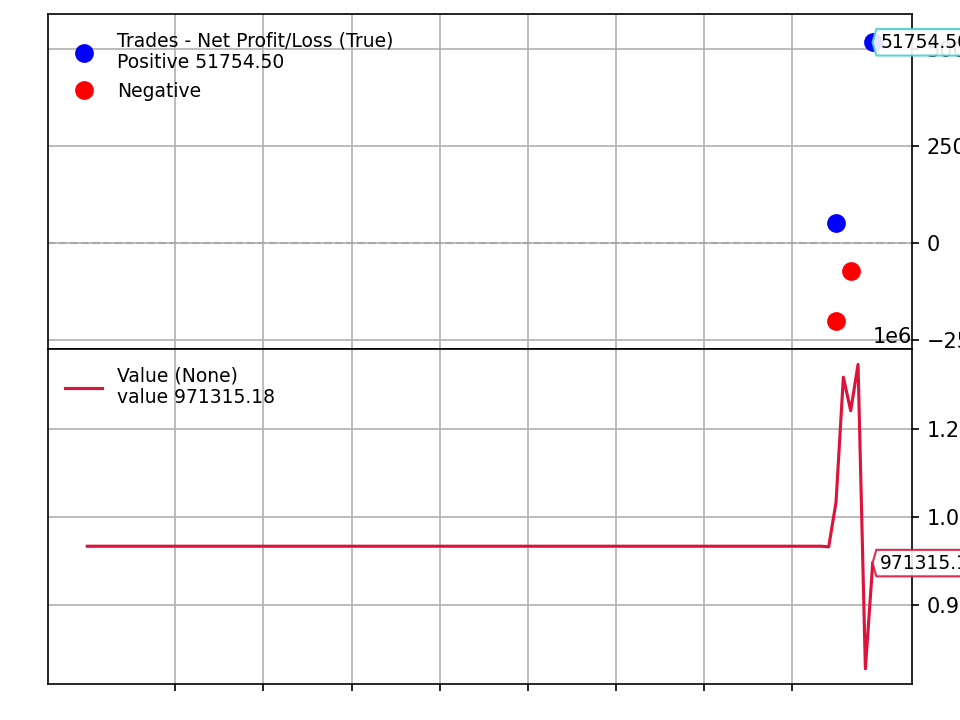

In [2]:
# 引入python3.X的一些特性，用于兼容python3.X
from __future__ import (absolute_import,division,print_function,
                        unicode_literals)

import backtrader as bt
import datetime
import pandas as pd

# class half_half_balance(bt.Strategy):
    
#     def __init__(self):
#         pass
    
#     def next(self):
#         today = self.data.datetime.date()
#         year,month = today.year,today.month
#         if month==12:
#             this_month_length = (datetime.datetime(year+1,1,1)-datetime.datetime(year,month,1)).days
#         else:
#             this_month_length = (datetime.datetime(year,month+1,1)-datetime.datetime(year,month,1)).days
#         if today.day == this_month_length:  #月底那一天rebalance
#             for column_name in weight.columns:
#                 for i in weight.index:
#                     ratio = weight.loc[i,column_name]
#                     self.order_target_percent(target=ratio,data=column_name)
#             # self.order_target_percent(target=0.45,data='AAL')
#             # self.order_target_percent(target=0.45,data='A')
#             #要留一部分，不应满仓，可供顾客赎回    
  
# weights = pd.read_csv("D:/CUHK/yr4 sem1/FINA380/pythonProject/final project/wgt.csv",index_col = 0)
weights = pd.read_csv("wgt.csv",index_col = 0)


class highest_sharpe_ratio(bt.Strategy):
    
    def __init__(self):
        pass
    
    def next(self):
        
        today = self.data.datetime.date()
        print(today)

        year,month = today.year,today.month
        if month==12:
            this_month_length = (datetime.datetime(year+1,1,1)-datetime.datetime(year,month,1)).days
        else:
            this_month_length = (datetime.datetime(year,month+1,1)-datetime.datetime(year,month,1)).days

        if today.day == this_month_length:
            for column_name in weights.columns:
                for i in weights.index:
                    ratio = weights.loc[i,column_name]
                    self.order_target_percent(target=ratio,data=column_name)
        
        print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

if __name__ == '__main__':

    # 1.creating a cerebro
    cerebro = bt.Cerebro(stdstats=False)
    cerebro.addobserver(bt.observers.Trades)
    cerebro.addobserver(bt.observers.BuySell)
    cerebro.addobserver(bt.observers.Value)
    cerebro.broker.set_cash(1000000.0)
        
    path1 = 'stock_data1/'
    symbols = pd.read_csv('S&P500_ticker1.csv', usecols=['Symbol'])
    for symbol in symbols.values:
        file_path = path1 + symbol[0] + '.csv'
        price_matrix = pd.read_csv(file_path,
                                    index_col='Date',
                                    parse_dates=True)
        # price_matrix.rename(columns={'Open':'open','High':'high','Low':'low','Close':'close','Volumn':'volume'},inplace=True)
        datafeed = bt.feeds.PandasData(dataname=price_matrix,plot=False)
        cerebro.adddata(datafeed,name=symbol[0])
    
    # 3.add strategies
    cerebro.addstrategy(highest_sharpe_ratio)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio)
    cerebro.addanalyzer(bt.analyzers.DrawDown)
    
    # 4.run
    res = cerebro.run()[0]
    print('value:',cerebro.broker.get_value())
    print('SharpeRatio:',res.analyzers.sharperatio.get_analysis())
    print('DrawDown:',res.analyzers.drawdown.get_analysis())
        
    # 5.plot results
    cerebro.plot(style='candle',volume=False)
    
